# Recruitment Experiment

In developing lifelong learning algorithms, prior work has involved two main approaches: building and reallocating. Building involves adding new resources to support the arrival of new data, whereas reallocation involves compression of representations to make room for new ones. However, biologically, there is a spectrum between these two modes.

In order to examine whether current resources could be better leveraged, we test a range of approaches: **recruitment** of the best-performing existing trees, **building** new trees completely (the default approach used by lifelong classification forests), ignoring all prior trees (essentially an uncertainty forest), and a **hybrid** between building and recruitment.

This experiment examines the performance of these four approaches based on the available training sample size.

In [3]:
import numpy as np
import keras

import matplotlib.pyplot as plt

import functions.recruitment_functions as fn

**Note:** This notebook tutorial uses functions stored externally within `functions/recruitment_functions.py` to simplify presentation of code. These functions are imported above, along with other libraries.

## Recruitment Within Datasets: CIFAR10x10

### The CIFAR-100 Dataset

The classification problem that we examine in this tutorial makes use of the [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), which is a labeled subset of the 80 million tiny images dataset. There are 100 classes ("fine" labels), containing 600 32x32-pixel images each (500 training and 100 testing). These 100 classes are grouped into 20 superclasses ("coarse" labels). Let's import the data:

In [2]:
# import data 
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()

To give a quick overview of what these data look like, let's plot the first five images in the training dataset.

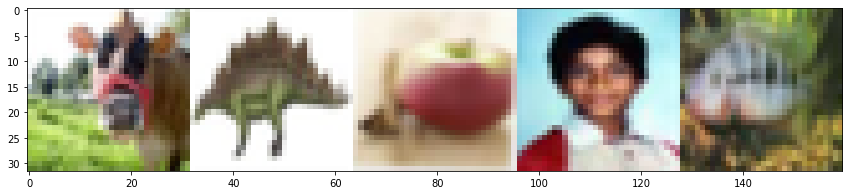

In [3]:
# plot example data
plt.figure(figsize=(15,3))
plt.imshow(np.hstack((X_train[0],X_train[1],X_train[2],X_train[3],X_train[4])))
plt.show()

### The Experiment

Now that we have imported the CIFAR-100 dataset, we can prepare to run the experiment. The function for running the experiment, `experiment`, can be found within `functions/recruitment_functions.py`.

We first declare the hyperparameters to be used for the experiment, which are as follows:
- `ntrees`: number of trees
- `reps`: number of repetitions to run the experiment for
- `estimation_set`: size of set used to train for 10th task, given as proportion (`1-estimation_set` is the size of the set used for validation, the selection of best trees)
- `num_points_per_task`: total number of points per run
- `num_points_per_forest`: number of points per forest (each training iteration/task)
- `task_10_sample`: number of samples to train on for the 10th task

In [4]:
############################
### Main hyperparameters ###
############################
ntrees = 50
reps = 5 #30
estimation_set = 0.63
num_points_per_task = 5000 
num_points_per_forest = 500 
task_10_sample = 10*np.array([10, 50, 100, 200, 350, 500])

Because the images are presented as 3D arrays, where the third dimension contains the values of the red, blue, and green channels, respectively, and are divided into training and testing sets of size 500 and 100, as mentioned earlier, we must do a little more preprocessing to get these data into a form suited for the progressive learner.

Here, we recombine the pre-established training and testing sets into one large dataset and reshape the arrays into a 1-dimensional string of numbers. We then call the `sort_data` command to divide the data into training and testing sets for each task.

In [5]:
# reformat data
data_x = np.concatenate([X_train, X_test])
data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2] * data_x.shape[3]))
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

# sort data
train_x_across_task, train_y_across_task, test_x_across_task, test_y_across_task = fn.sort_data(data_x,data_y,num_points_per_task)

To replicate the experiment found in [Vogelstein, et al. (2020)](https://arxiv.org/pdf/2004.12908.pdf), we use the hyperparameter values established previously to train a lifelong forest on the first nine CIFAR 10x10 tasks, where we have `50` trees (`ntrees`) and `500` samples (`num_points_per_forest`) for each set.

For the 10th task, we use training sample sizes ranging from `100` to `5000` (`task_10_sample`) and obtain generalization errors for each of the following approaches:
1. **Building (default for lifelong forests)**, which involves training `ntrees=50` new trees,
2. **Uncertainty forest**, which ignores all prior trees,
3. **Recruiting**, which selects the `ntrees=50` (out of all 450 existing trees) that perform best on the newly introduced 10th task, and
4. **Hybrid**, which both builds `ntrees/2=25` new trees and recruits the `ntrees/2=25` best-performing trees.

Let's call our `experiment` function and give it a run!

In [ ]:
# run the experiment
mean_acc_dict, std_acc_dict = fn.experiment(
    train_x_across_task, 
    train_y_across_task, 
    test_x_across_task, 
    test_y_across_task,
    ntrees, 
    reps, 
    estimation_set, 
    num_points_per_task,
    num_points_per_forest, 
    task_10_sample
)

As you can see from the code above, our `experiment` function returns two dictionaries,`mean_acc_dict` and `std_acc_dict`, that respectively contain the means and standard deviations of the generalization errors for each approach (building, UF, recruiting, hybrid) over all repetitions. The dictionary keys correspond to each approach.

### Visualizing the Results

Let's visualize the results of the experiment through the `recruitment_plot` function, which can be found in `functions/recruitment_functions.py`.

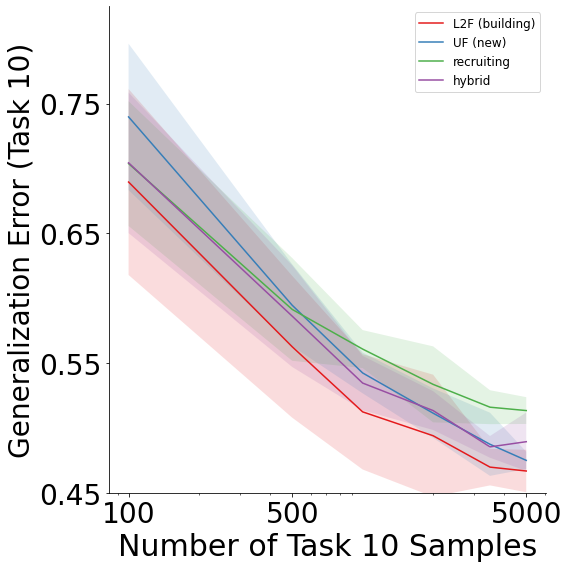

In [13]:
# plot results
fn.recruitment_plot(mean_acc_dict, std_acc_dict, task_10_sample)

From these results, we see that lifelong forests outperform all other approaches except at 5000 task 10 samples, which illustrate how relative performance depends on available resources and sample size.

## Recruitment Between Datasets: MNIST/Fashion-MNIST

Another thing that is of interest is whether we are able to show improvement in performance *between* similar datasets and how the four schemes (recruitment, building, UF, and hybrid) impact this performance. For this, we look to the MNIST and Fashion-MNIST datasets.

### MNIST & Fashion-MNIST Datasets

The MNIST dataset contains 60,000 training samples and 10,000 testing samples of handwritten numerical digits (from 0-9), presented as 28x28 grayscale images. Fashion-MNIST, similarly, also contains 60,000 training and 10,000 testing samples in the form of 28x28 grayscale images, and it was intended to serve as an alternative to MNIST for benchmarking machine learning algorithms. These features make the two datasets ideal for studying recruitment between two datasets due to their similarity in structure.

### Recruitment on MNIST and Fashion-MNIST Individually
Before we are able to examine the recruitment performance between datasets, it is important that
we first look at their individual performance, so that we have a rough benchmark for how these
datasets will perform. We use the same hyperparameters for the benchmarking recruitment, as follows:

In [3]:
############################
### Main hyperparameters ###
############################
ntrees = 50
n_tasks = 5
reps = 5 
estimation_set = 0.63
num_points_per_task = 10000
num_points_per_forest = 1000 
test_points_per_task = 1000
task_10_sample = 10*np.array([10, 50, 100, 200, 350, 500, 1000])

As can be seen above, we are using 5 tasks for each dataset, meaning that each task contains the data
for two numbers (in the case of MNIST) or two clothing types (in the case of Fashion-MNIST).

#### Recruitment on MNIST

The MNIST results are as follows:

In [ ]:
# import and sort data 
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
train_x_across_task, train_y_across_task, test_x_across_task, test_y_across_task = fn.sort_data_mnist(x_train, y_train, x_test, y_test, num_points_per_task, test_points_per_task, n_tasks)

In [ ]:
# run the experiment
mean_acc_dict, std_acc_dict = fn.experiment_mnist(
    train_x_across_task, 
    train_y_across_task, 
    test_x_across_task, 
    test_y_across_task,
    ntrees, 
    n_tasks,
    reps, 
    estimation_set, 
    num_points_per_task,
    num_points_per_forest, 
    task_10_sample
)

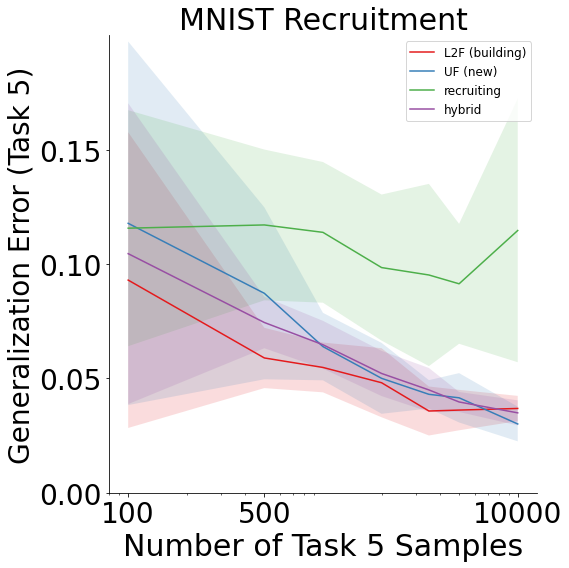

In [4]:
# plot results
fn.recruitment_plot_mnist(mean_acc_dict, std_acc_dict, task_10_sample)

#### Recruitment on Fashion-MNIST
Likewise, the Fashion-MNIST results are as follows:

In [ ]:
# import and sort data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
train_x_across_task, train_y_across_task, test_x_across_task, test_y_across_task = fn.sort_data_mnist(x_train, y_train, x_test, y_test, num_points_per_task, test_points_per_task, n_tasks)

In [ ]:
# run the experiment
mean_acc_dict, std_acc_dict = fn.experiment_mnist(
    train_x_across_task, 
    train_y_across_task, 
    test_x_across_task, 
    test_y_across_task,
    ntrees, 
    n_tasks,
    reps, 
    estimation_set, 
    num_points_per_task,
    num_points_per_forest, 
    task_10_sample
)

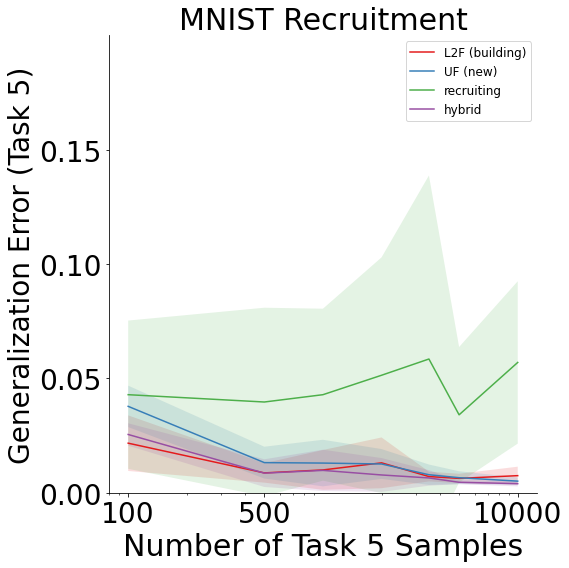

In [5]:
# plot results
fn.recruitment_plot_mnist(mean_acc_dict, std_acc_dict, task_10_sample)

Both MNIST and Fashion-MNIST display improvement in generalization error as the number of samples on the last task increases for all schemes except recruiting forests.

### Recruitment Between MNIST and Fashion-MNIST

Now that we have the data for the individual datasets, let's look at the performance between the two.
Essentially, we set the MNIST data as the first task and Fashion-MNIST as the second task, with
ten labels in each task. For this, we use the following hyperparameters:

In [4]:
############################
### Main hyperparameters ###
############################
ntrees = 50
n_tasks = 2
reps = 5 #30
estimation_set = 0.63
num_points_per_task = 50000 
num_points_per_forest = 25000 
test_points_per_task = 10000
task_10_sample = 10*np.array([10, 50, 100, 500, 1000, 2500, 5000])

Let's run the experiment, as before.

First, we load the data:

In [ ]:
# import data 
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = keras.datasets.mnist.load_data()
(fmnist_x_train, fmnist_y_train), (fmnist_x_test, fmnist_y_test) = keras.datasets.fashion_mnist.load_data()

Then, we reformat it and sort into train and test samples:

In [ ]:
# reformat data
x_train = np.concatenate((mnist_x_train, fmnist_x_train), axis=0)
x_test = np.concatenate((mnist_x_test, fmnist_x_test), axis=0)
y_train = np.concatenate((mnist_y_train, fmnist_y_train + 10), axis=0)
y_test = np.concatenate((mnist_y_test, fmnist_y_test + 10), axis=0)

In [ ]:
# sort data
train_x_across_task, train_y_across_task, test_x_across_task, test_y_across_task = fn.sort_data_mnist(x_train, y_train, x_test, y_test, num_points_per_task, test_points_per_task, n_tasks)

Next, we run the experiment:

In [ ]:
# run the experiment
mean_acc_dict, std_acc_dict = fn.experiment_mnist(
    train_x_across_task, 
    train_y_across_task, 
    test_x_across_task, 
    test_y_across_task,
    ntrees, 
    n_tasks,
    reps, 
    estimation_set, 
    num_points_per_task,
    num_points_per_forest, 
    task_10_sample
)

And plot the results:

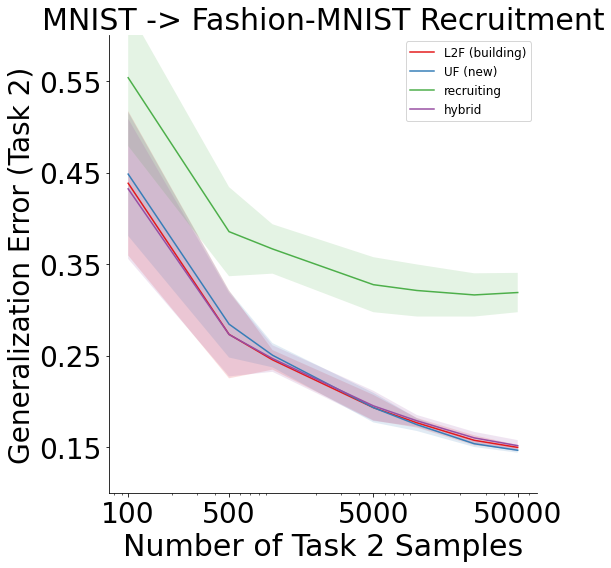

In [5]:
# plot results
fn.recruitment_plot_mnist_between(mean_acc_dict, std_acc_dict, task_10_sample)

We can see that when performed between datasets, there is still evidence of recruitment, but the recruiting scheme becomes progressively worse in comparison for this example.